the goal is to create a notebook that would allow automatic processing of pairs of SAR images and related model data.

First part collect all variables which setting later could go to configuration file

Second part combines all steps of processing with intermidiate plotting and saving data. Later it should split to different python modules and run by a function from a separate .py with one main method, for example def rub_int_forecast_analysis which would use confic variables

I will try to organize code so rask would be in once cell so it would be convinient to make python files afterwords

At the end I can split this notebook to modules and execution part based on the hashtag at teh top of each cell (maybe automatically with chatGPT)
Would be great if variables from config files or any other varoables used in different modules would be changed to module_name.variable

In [2]:
#Import modules for exwcutions

# If using a new container, a different version of matplotlib should be installed
# To avoid the error while plotting "AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'"
# Otherwise image should be changed again 
#!pip install --user matplotlib==3.5.2

import xarray as xr

import re

from nansat import Nansat, Domain, NSR

#from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

In [3]:
#module

# ---------------------------------------------------------------------- #
# Name :        config.py
# Purpose :     S1 Image class definitions and functions for preparing pairs of SAR1 and SAR2
# ---------------------------------------------------------------------- #

# ---------------------------------------------------------------------- #
# USER DEFINED PARAMETERS 
#
# ---------------------------------------------------------------------- #


# -----------------------------
# Directories and File Paths
# -----------------------------

# Path to directory containing geocoded HH-polarized Sentinel-1 images
path_to_HH_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HH_HV_160_for_batch_processing/test/HH_160'
#path_to_HH_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_40'

# Path to directory containing geocoded HV-polarized Sentinel-1 images
path_to_HV_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HH_HV_160_for_batch_processing/test/HV_160'
#path_to_HV_files = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_40'

# Directory containing the SAFE formatted Sentinel-1 images
safe_folder = '/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/safe'

output_folder =  '/home/jovyan/experiment_data/2022-2023_48h_experiment/batch_output'
# -----------------------------
# Regular Expressions
# -----------------------------

# Regular expression for matching geocoded Sentinel-1 product file names
# Such suffixes as Orb, Cal, TC, polarisation band and then resolution are added during geocoding based on steps and parameters
# Geocoding is happening in a separate environment using snappy module
S1_prod_regex = (r'S1[AB]{1}_EW_GRDM_1[A-Z]{3}_(?P<start_timestamp>[0-9]{8}T[0-9]{6})_'
                r'[0-9]{8}T[0-9]{6}_[0-9]{6}_[0-9A-Z]{6}_(?P<product_id>[0-9A-Z]{4})_Orb_Cal_TC_'
                r'(?P<polarisation>H[HV]{1})_(?P<resolution>[0-9]{1,4})')

# Regular expression for matching SAFE formatted Sentinel-1 file names
S1_safe_regex = (r'S1[AB]{1}_EW_GRDM_1[A-Z]{3}_(?P<start_timestamp>[0-9]{8}T[0-9]{6})_'
                r'[0-9]{8}T[0-9]{6}_[0-9]{6}_[0-9A-Z]{6}_(?P<product_id>[0-9A-Z]{4})')


# Compile the regular expression for matching Sentinel file names.
S1_prod_regex = re.compile(S1_prod_regex)  
S1_safe_regex = re.compile(S1_safe_regex) 


# -----------------------------
# Grid Configuration
# -----------------------------

# Load the data grid based on a model dataset
data_grid = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_surface/2023/09/07/T18Z/barents_sfc_20230907T18Zm23.nc")

# Extract the X, Y, longitude, and latitude coordinates from the dataset
# It will be a base for creating a model domain for fretriving sar drift with the same resolution as Barents2.5 data 
# and for comparison domain where all SAR images (real and forecasted) will be projected to  .
X = data_grid['X']
Y = data_grid['Y']
lon = data_grid['lon']
lat = data_grid['lat']

# Extract the proj4 string defining the dataset's Lambert Conformal projection
proj4 = data_grid.projection_lambert.proj4

# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

In [4]:
#module

# ---------------------------------------------------------------------- #
# Name :        s1_preparation.py
# Purpose :     S1 Image class definitions and functions for preparing pairs of SAR1 and SAR2
# ---------------------------------------------------------------------- #

import re
import datetime
import os

''' 
Comments
----------

SAFE files were geocoded separatly usign snappy module usifn following parameters:

sentinel_processor(in_folder, output_folder, polarization_mode = 'DH', polarization_bands = 'HH,HV', pixel_spacing = 160, crs = custom_crs_wkt, resampling_method = 'BILINEAR_INTERPOLATION')

Regular expression for output file differs from the original safe files by having a few extra suffixes at the end, for example:
S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV_160.tif

custom_crs_wkt = 'PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],
                PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",77.5],PARAMETER["central_meridian",-25],PARAMETER["standard_parallel_1",77.5],
                PARAMETER["standard_parallel_2",77.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],
                AXIS["Northing",NORTH]]'
'''

class S1Image:
    
    ''' 
    Container for Sentinel-1 geocoded product. 
    
    Represents the essential details of a Sentinel-1 product 
    that has been processed and geocoded. The class is capable 
    of extracting attributes like timestamp, polarisation_band, 
    and resolution from the filename using a predefined regex pattern.
    
    Attributes
    ----------
    filepath : str
        - Full path to the Sentinel-1 product file.
    filename : str
        - Name of the Sentinel-1 product file.
    timestamp : datetime.datetime
        - Acquisition time of the product.
    polarisation_band : str
        - Polarisation band of the product (e.g., HH, HV).
    resolution : int
        - Resolution of the product (e.g., 160).
    '''
        
    @classmethod
    def find_safe_filepath(cls, filename):
        prod_match = S1_prod_regex.match(filename)
        if not prod_match:
            return None
        for safe_file in os.listdir(safe_folder):
            safe_match = S1_safe_regex.match(safe_file)
            if safe_match and prod_match.group('product_id') == safe_match.group('product_id'):
                return os.path.join(safe_folder, safe_file)
        return None


    def __init__(self, filepath):
        self.filepath = filepath
        self.filename = os.path.basename(filepath)
        # Attempt to match the filename against the predefined regex pattern.
        match = S1_prod_regex.search(self.filename)
        if not match:
            raise ValueError(f"File {self.filename} does not match the expected pattern.")
        self.timestamp = datetime.datetime.strptime(match.group('start_timestamp'), '%Y%m%dT%H%M%S')
        self.polarisation_band = match.group('polarisation')
        self.resolution = int(match.group('resolution'))
        self.safe_filepath = self.find_safe_filepath(self.filename)
        
        
    def __repr__(self):
        return f"S1Image(polarisation={self.polarisation_band}, timestamp={self.timestamp.strftime('%Y%m%dT%H%M%S')})"

    
        
# Function to collect and create S1Image objects for all Sentinel files in a directory.
def collect_sentinel_files(directory):
    # Initialize an empty list to store S1Image objects
    sentinel_files = []

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        # Check if the file has a .tif extension
        if filename.endswith('.tif'):
            # Create the full path to the file
            full_path = os.path.join(directory, filename)
            
            # Create a S1Image object and add it to the list
            try:
                sentinel_file = S1Image(full_path)
                sentinel_files.append(sentinel_file)
            except ValueError:
                # This will skip files that don't match the expected pattern
                continue
    # Check if the list is empty and raise a warning

    # Check if the list is empty and raise an exception
    if not sentinel_files:
        raise ValueError("No objects were created as no files matched the criteria.")
        
    # Sort the list of S1Image objects by their timestamp
    sorted_files = sorted(sentinel_files, key=lambda x: x.timestamp)
    
    return sorted_files
    

# Function to get pairs of Sentinel files where the difference in their timestamps is within a given limit.
def get_pairs_within_time_limit(files, hours=60):
    pairs = []
    for i in range(len(files)):
        for j in range(i+1, len(files)):
            if (files[j].timestamp - files[i].timestamp).total_seconds() <= hours * 3600:
                pairs.append((files[i], files[j]))
            else:
                break  # break inner loop since the list is sorted and no other pairs will fit the criteria
    return pairs

In [5]:
# Execution

# Collect SentinelFile objects for files in the HH and HV directories.
HH_files = collect_sentinel_files(path_to_HH_files)
HV_files = collect_sentinel_files(path_to_HV_files)

# Get pairs of SentinelFile objects where their timestamps are within 60 hours of each other.
HH_pairs = get_pairs_within_time_limit(HH_files)
HV_pairs = get_pairs_within_time_limit(HV_files)

# Print details for each pair.
for index, pair in enumerate(HV_pairs, start=1):  # start=1 makes the index start from 1
    print(f'Pair {index}:')
    print(f'SAR1: {pair[0].filename} \ntimestamp: {pair[0].timestamp}; resolution: {pair[0].resolution}\n'
          f'SAR2: {pair[1].filename} \ntimestamp: {pair[1].timestamp}; resolution: {pair[1].resolution}')

Pair 1:
SAR1: S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV_160.tif 
timestamp: 2022-11-20 08:01:55; resolution: 160
SAR2: S1A_EW_GRDM_1SDH_20221122T074535_20221122T074639_046004_05816B_9FC9_Orb_Cal_TC_HV_160.tif 
timestamp: 2022-11-22 07:45:35; resolution: 160
Pair 2:
SAR1: S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif 
timestamp: 2023-02-12 08:01:51; resolution: 160
SAR2: S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014_Orb_Cal_TC_HV_160.tif 
timestamp: 2023-02-14 07:45:31; resolution: 160


In [6]:
#module

# ---------------------------------------------------------------------- #
# Name :        SAR1_SAR2_drift_retrivial.py
# Purpose :     Retrieve reference drift for  further comparison with the model data and reference forecast.  
# ---------------------------------------------------------------------- #
'''
purpose:
1. for HV open pair one
2. Calculate feature tracking, pattren matching and safe as images:
 - r, hpm, ssmi
 - drift 
3. Repeat the same for pair in HH_files
4. Compare hpm for hh and hv and create combined r, h, ssmi, u, v
 - as output safe a plot showing when hh > hv and an img
 5. Expor u and v forcsv for forecastin
'''

'\npurpose:\n1. for HV open pair one\n2. Calculate feature tracking, pattren matching and safe as images:\n - r, hpm, ssmi\n - drift \n3. Repeat the same for pair in HH_files\n4. Compare hpm for hh and hv and create combined r, h, ssmi, u, v\n - as output safe a plot showing when hh > hv and an img\n 5. Expor u and v forcsv for forecastin\n'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from osgeo import gdal
from osgeo import osr
from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

from sea_ice_drift.ftlib import feature_tracking
#from sea_ice_drift.pmlib import pattern_matching as pattern_matching1

import sys
sys.path.append(r'./nersc_drift_algorithm/sea_ice_drift')
from pmlib_with_ssim import pattern_matching

%matplotlib inline

In [8]:
#after change pair number from 1 to i and get it into loop?
# sar1 and sar2 are the first par from pairlist; HV_pairs[1][0] and  HV_pairs[1][1] and which would be substitute for sar_pairs[1][0], sar_pairs[1][1] after switching only to safe files


def prepare_nansat_objects(sar1, sar2, output_folder, polarization):
    
    """
    Prepare and plot Nansat objects from given SAR images.
    
    The function creates Nansat objects out of a pair of SAR images and saves a side-by-side visualization of the
    processed images. The generated plots and images are saved to a specified output folder, organized by timestamps 
    and polarization.

    Parameters:
    - sar1: The first SAR image object with attributes 'safe_filepath' and 'timestamp'.
    - sar2: The second SAR image object with attributes 'safe_filepath' and 'timestamp'.
    - polarization (optional): The polarization to be used, either 'HV' or 'HH'.

    Returns:
    - n1: Nansat object of the first SAR image after processing.
    - n2: Nansat object of the second SAR image after processing.
    
    """
    
    f1 = sar1.safe_filepath  #if I don't use tiff file I need to change class so it was no hh and hv, but just safe file with timestamp and path
    f2 = sar2.safe_filepath

    n1 = get_n(f1, bandName= f'sigma0_{polarization}', remove_spatial_mean=True) 
    n2 = get_n(f2, bandName= f'sigma0_{polarization}', remove_spatial_mean=True)
    
    
    # Create directory for saving outputs for each pair of images
    output_dir_name = os.path.join(output_folder, f"{sar1.timestamp.strftime('%Y%m%dT%H%M%S')}_{sar2.timestamp.strftime('%Y%m%dT%H%M%S')}_{polarization}")
    os.makedirs(output_dir_name, exist_ok=True)
    
    # Create directory for saving plots
    plots_dir = os.path.join(output_dir_name, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    #Plot
    plt.close('all')
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    
    # Set background color to white
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('white')
    fig.set_facecolor('white')
    
    im1 = ax[0].imshow(n1[1], clim=[0, 255])
    ax[0].axis('off')
    #plt.colorbar(im0, ax=ax[0])
    im2 = ax[1].imshow(n2[1], clim=[0, 255])
    ax[1].axis('off')
    #plt.colorbar(im1, ax=ax[1])
    cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
    cbar = fig.colorbar(im2, cax=cax)
    #plt.colorbar(im3, ax=ax[2])

    ax[0].set_title(f"SAR1 {polarization} - {sar1.timestamp.strftime('%Y%m%dT%H%M%S')}")
    ax[1].set_title(f"SAR2 {polarization} - {sar2.timestamp.strftime('%Y%m%dT%H%M%S')}")

    # Save the figure without displaying it
    save_path = os.path.join(plots_dir, f"n1_n2_{polarization}.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')

    # Close it after saving
    plt.close(fig)
  
    return n1, n2, plots_dir

def run_feature_tracking(n1, n2, plots_dir):  
    
    """
    Execute feature tracking between two SAR images and visualize the results.

    This function performs feature tracking between two Nansat objects representing SAR images. 
    It identifies and matches keypoints (features) between the images, then visualizes:
    1. The matched keypoints in geographic coordinates.
    2. The ice drift vectors superimposed on the first SAR image.

    Parameters:
    - n1: The first Nansat object representing a SAR image 1.
    - n2: The second Nansat object representing a SAR image 2.
    - plots_dir: Directory path where the visualizations will be saved.

    Returns:
    - c1, r1: Column and row coordinates of matched keypoints in the first image.
    - c2, r2: Column and row coordinates of matched keypoints in the second image.
    - lon1b, lat1b: Longitude and latitude coordinates of the border of the first image.

    """
        
    # get start/end coordinates in the image coordinate system (colums/rows)  
    c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

    # Plot identified and matched keypoints in geographic coordinates

    # convert row/column coordinates of matched features to lon/lat
    lon1ft, lat1ft = n1.transform_points(c1, r1)
    lon2ft, lat2ft = n2.transform_points(c2, r2)

    # get lon/lat coordinates of the border of images
    lon1b, lat1b = n1.get_border()
    lon2b, lat2b = n2.get_border()


    # get hi-res landmask
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])

    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
    ax.add_feature(land_50m, zorder=0, edgecolor='black')
    ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
    ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
    ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
    ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
    ax.legend()

    # Save the figure without displaying it
    save_path = os.path.join(plots_dir, f"ft_matching_points.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)


    # Plot ice drift on top of image_1

    # end points in image_1 coordinate system
    n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

    # ice drift components in image_1 coordinate system
    dr = n1r2 - r1
    dc = n1c2 - c1

    # border of image_2 in image_1 coordinate system
    n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

    # plot of ice drift.
    fig = plt.figure(figsize=(10,10))
    plt.imshow(n1[1], cmap='gray')
    plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
    plt.plot(n1lon2b, n1lat2b, 'k.-')

    # Save the figure without displaying it
    save_path = os.path.join(plots_dir, f"ft_drift_vectors.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    return c1, r1, c2, r2, lon1b, lat1b

def prepare_grid(n1, n2, srs, lon, lat, buffer):
    """
    Prepare a subset grid based on teh model grid and based on the bounds of the SAR image, expanded by a buffer.
    
    The function extracts a subset of the grid from the model based on the bounds 
    of the SAR image and adds a buffer to the subset. This buffered subset grid 
    is used for pattern matching to ensure that the drift output aligns seamlessly 
    with the model data.

    Parameters:
    - srs : Desired spatial reference system.
    - lon (xarray.DataArray): Longitudes from the model grid.
    - lat (xarray.DataArray): Latitudes from the model grid.
    - buffer (int): Number of pixels to expand the subset by.

    Returns:
    - X_subset (xarray.DataArray): Subset of X-coordinates based on the SAR image bounds (expanded by buffer).
    - Y_subset (xarray.DataArray): Subset of Y-coordinates based on the SAR image bounds (expanded by buffer).
    - lon_subset (xarray.DataArray): Subset of longitudes based on the SAR image bounds (expanded by buffer).
    - lat_subset (xarray.DataArray): Subset of latitudes based on the SAR image bounds (expanded by buffer).
    - lon1pm (array-like): Longitudes prepared for pattern matching.
    - lat1pm (array-like): Latitudes prepared for pattern matching.
    """
    # get lon/lat coordinates of the border of images
    lon1b, lat1b = n1.get_border()
    lon2b, lat2b = n2.get_border()

    #Get bound in rows and columns correspoding to the image borders set above
    r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
    
    # Add buffer in pixels to make a subset biger to take into account drift
    min_row, max_row, min_col, max_col = min(r) - buffer, max(r) + buffer, min(c) - buffer, max(c) + buffer
    
    # Extract the subset grif out of the model grid based on the image bounds
    #That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
    X_subset = X[min_col:max_col+1]
    Y_subset = Y[min_row:max_row+1]
    lon_subset = lon[min_row:max_row+1, min_col:max_col+1]
    lat_subset = lat[min_row:max_row+1, min_col:max_col+1]


    # Prepare coordinates for patern matching input
    lon1pm = lon_subset.data
    lat1pm = lat_subset.data

    # Set up coordinates in meters for visualizing the pattern matching results.
    x1pm, y1pm = np.meshgrid(X_subset, Y_subset)
    return X_subset, Y_subset, lon_subset, lat_subset, lon1pm, lat1pm

Here should be HH and HV processing

In [9]:
n1, n2, plots_dir =  prepare_nansat_objects(HV_pairs[1][0], HV_pairs[1][1], output_folder, polarization='HV')

c1, r1, c2, r2, lon1b, lat1b = run_feature_tracking(n1, n2, plots_dir)

VMIN:  -3.9498636960983275
VMAX:  5.663959283828735
VMIN:  -3.5571017265319824
VMAX:  5.484246134757996
Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 37701
Domain filter: 50000 -> 48850
Keypoints matched 3.609405279159546
Ratio test 0.600000 found 1552 keypoints
MaxDrift filter: 1552 -> 1552
LSTSQ filter: 1552 -> 1523


In [10]:
# Prepare subset model grid for domains and pattern matching
X_subset, Y_subset, lon_subset, lat_subset, lon1pm, lat1pm = prepare_grid(n1, n2, srs, lon, lat, buffer=0)
# Set a model domain 
mod_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 2500 2500')

# Set a comparison domain 
dst_dom = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')

fig, axs = plt.subplots(1,1,figsize=(8,8))
axs.plot(*mod_dom.get_border(), '.-', label='Model subset domain')
axs.plot(*n1.get_border(), '.-', label='First S1 image')
axs.plot(*n2.get_border(), '.-',  label='First S2 image')
plt.legend()
#plt.show()
# Save the figure without displaying it
save_path = os.path.join(plots_dir, f"images_vs_domain_borders.png")
fig.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close(fig)

In [32]:
data_range=n2[1].max() - n2[1].min()

In [33]:
data_range

255

In [ ]:
 best_ssim = compare_ssim(best_template, image2[best_ij[0]:best_ij[0]+img_size, best_ij[1]:best_ij[1]+img_size], data_range=image2.max() - image2.min())

In [30]:
# Name:    pmlib.py
# Purpose: Container of Pattern Matching functions
# Authors:      Anton Korosov, Stefan Muckenhuber
# Created:      21.09.2016
# Copyright:    (c) NERSC 2016
# Licence:
# This file is part of SeaIceDrift.
# SeaIceDrift is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, version 3 of the License.
# http://www.gnu.org/licenses/gpl-3.0.html
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
from __future__ import absolute_import, print_function

import time
from multiprocessing import Pool

import numpy as np
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from osgeo import gdal
import cv2

from nansat import NSR

from skimage.metrics import structural_similarity as compare_ssim


from sea_ice_drift.lib import (interpolation_poly,
                               interpolation_near,
                               get_drift_vectors,
                               _fill_gpi)

shared_args = None
shared_kwargs = None

def get_hessian(ccm, hes_norm=True, hes_smth=False, **kwargs):
    """ Find Hessian of the input cross correlation matrix <ccm>

    Parameters
    ----------
    ccm : 2D numpy array, cross-correlation matrix
    hes_norm : bool, normalize Hessian by AVG and STD?
    hes_smth : bool, smooth Hessian?

    """
    if hes_smth:
        ccm2 = nd.filters.gaussian_filter(ccm, 1)
    else:
        ccm2 = ccm
    # Jacobian components
    dcc_dy, dcc_dx = np.gradient(ccm2)
    # Hessian components
    d2cc_dx2 = np.gradient(dcc_dx)[1]
    d2cc_dy2 = np.gradient(dcc_dy)[0]
    hes = np.hypot(d2cc_dx2, d2cc_dy2)
    if hes_norm:
        hes = (hes - np.median(hes)) / np.std(hes)

    return hes

def get_distance_to_nearest_keypoint(x1, y1, shape):
    ''' Return full-res matrix with distance to nearest keypoint in pixels
    Parameters
    ----------
        x1 : 1D vector - X coordinates of keypoints
        y1 : 1D vector - Y coordinates of keypoints
        shape : shape of image
    Returns
    -------
        dist : 2D numpy array - image with distances
    '''
    seed = np.zeros(shape, dtype=bool)
    seed[np.uint16(y1), np.uint16(x1)] = True
    dist = nd.distance_transform_edt(~seed,
                                    return_distances=True,
                                    return_indices=False)
    return dist

def get_initial_rotation(n1, n2):
    ''' Returns angle <alpha> of rotation between two Nansat <n1>, <n2>'''
    corners_n2_lons, corners_n2_lats = n2.get_corners()
    corner0_n2_x1, corner0_n2_y1 = n1.transform_points([corners_n2_lons[0]], [corners_n2_lats[0]], 1)
    corner1_n2_x1, corner1_n2_y1 = n1.transform_points([corners_n2_lons[1]], [corners_n2_lats[1]], 1)
    b = corner1_n2_x1 - corner0_n2_x1
    a = corner1_n2_y1 - corner0_n2_y1
    alpha = np.degrees(np.arctan2(b, a)[0])
    return alpha

def get_template(img, c, r, a, s, rot_order=0, **kwargs):
    """ Get rotated and shifted square template
    Parameters
    ----------
        img : ndarray, input image
        c : float, center column coordinate (pixels)
        r : float, center row coordinate (pixels)
        a : float, rotation angle (degrees)
        s : odd int, template size (width and height)
        order : int, transformation order
    Returns
    -------
        t : ndarray (s,s)[np.uint8], rotated template

    """
    # center on output template
    tc = int(s / 2.) + 1
    tc = np.array([tc, tc])

    a = np.radians(a)
    transform = np.array([[np.cos(a), -np.sin(a)],[np.sin(a), np.cos(a)]])
    offset = np.array([r, c]) - tc.dot(transform)

    t = nd.interpolation.affine_transform(
        img, transform.T, order=rot_order, offset=offset, output_shape=(s, s), cval=0.0, output=np.uint8)

    return t


def rotate_and_match(img1, c1, r1, img_size, image2, alpha0,
                     angles=[-3,0,3],
                     mtype=cv2.TM_CCOEFF_NORMED,
                     template_matcher=cv2.matchTemplate,
                     mcc_norm=False,
                     **kwargs):
    
    
    ''' Rotate template in a range of angles and run MCC for each
    Parameters
    ----------
        im1 : 2D numpy array - original image 1
        c1 : float - column coordinate of center on img1
        r1 : float - row coordinate of center on img1
        img_size : size of template
        image : np.uint8, subset from image 2
        alpha0 : float - angle of rotation between two SAR scenes
        angles : list - which angles to test
        mtype : int - type of cross-correlation
        template_matcher : func - function to use for template matching
        mcc_norm : bool, normalize MCC by AVG and STD ?
        kwargs : dict, params for get_hessian
    Returns
    -------
        dc : int - column displacement of MCC
        dr : int - row displacement of MCC
        best_a : float - angle of MCC
        best_r : float - MCC
        best_h : float - Hessian at highest MCC point
        best_result : float ndarray - cross correlation matrix
        best_template : uint8 ndarray - best rotated template

    '''
    res_shape = [image2.shape[0] - img_size +1]*2
    best_r = -np.inf
    for angle in angles:
        template = get_template(img1, c1, r1, angle-alpha0, img_size, **kwargs)
        if ((template.min() == 0) or
            (template.shape[0] < img_size or template.shape[1] < img_size)):
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

        result = template_matcher(image2, template, mtype)

        ij = np.unravel_index(np.argmax(result), result.shape)

        if result.max() > best_r:
            best_r = result.max()
            best_a = angle
            best_result = result
            best_template = template
            best_ij = ij
  
       

    best_h = get_hessian(best_result, **kwargs)[best_ij]
    dr = best_ij[0] - (image2.shape[0] - template.shape[0]) / 2.
    dc = best_ij[1] - (image2.shape[1] - template.shape[1]) / 2.

    if mcc_norm:
        best_r = (best_r - np.median(best_result)) / np.std(best_result)
    
    # Now, after finding the best match using cross-correlation, compute SSIM
    best_ssim = compare_ssim(best_template, image2[best_ij[0]:best_ij[0]+img_size, best_ij[1]:best_ij[1]+img_size], data_range=image2.max() - image2.min())
    return dc, dr, best_a, best_r, best_h, best_result, best_template, best_ssim 

def use_mcc(c1, r1, c2fg, r2fg, border, img1, img2, img_size, alpha0, **kwargs):
    """ Apply MCC algorithm for one point

    Parameters
    ----------
        c1 : float, column coordinate on image 1
        r1 : float, row coordinate on image 1
        c2fg : int, first guess column coordinate on image 2
        r2fg : int, first guess row coordinate on image 2
        border : int, searching distance (border around template)
        img1 : 2D array - full szie image 1
        img2 : 2D array - full szie image 2
        img_size : int, template size
        alpha0 : float, rotation between two images
        kwargs : dict, params for rotate_and_match, get_template, get_hessian
    Returns
    -------
        x2 : float, result X coordinate on image 2
        y2 : float, result X coordinate on image 2
        a : float, angle that gives highest MCC
        r : float, MCC
        h : float, Hessian of CC at MCC point

    """
    hws = int(img_size / 2.)
    image = img2[int(r2fg-hws-border):int(r2fg+hws+border+1),
                 int(c2fg-hws-border):int(c2fg+hws+border+1)]
    
    dc, dr, best_a, best_r, best_h, best_result, best_template, best_ssim  = rotate_and_match(img1, c1, r1,
                                                      img_size,
                                                      image,
                                                      alpha0,
                                                      **kwargs)
    c2 = c2fg + dc
    r2 = r2fg + dr

    return c2, r2, best_a, best_r, best_h, best_ssim 

def use_mcc_mp(i):
    """ Use MCC
    Uses global variables where first guess and images are stored
    Parameters
    ---------
        i : int, index of point
    Returns
    -------
        c2 : float, result X coordinate on image 2
        r2 : float, result X coordinate on image 2
        a : float, angle that gives highest MCC
        r : float, MCC
        h : float, Hessian of CC at MCC point

    """
    global shared_args, shared_kwargs

    # structure of shared_args:
    # c1pm1i, r1pm1i, c2fg, r2fg, brd2, img1, img2, img_size, alpha0, kwargs

 
    c2, r2, a, r, h, best_ssim = use_mcc(shared_args[0][i], 
                                    shared_args[1][i], 
                                    shared_args[2][i], 
                                    shared_args[3][i], 
                                    shared_args[4][i], 
                                    shared_args[5], 
                                    shared_args[6], 
                                    shared_args[7], 
                                    shared_args[8], 
                                    **shared_kwargs)

    
    if i % 100 == 0:
        print('%02.0f%% %07.1f %07.1f %07.1f %07.1f %+05.1f %04.2f %04.2f' % (
            100 * float(i) / len(shared_args[0]),
            shared_args[0][i], shared_args[1][i], c2, r2, a, r, h), end='\r')
    return c2, r2, a, r, h, best_ssim

def prepare_first_guess(c2pm1, r2pm1, n1, c1, r1, n2, c2, r2, img_size,
                        min_fg_pts=5,
                        min_border=20,
                        max_border=50,
                        old_border=True, **kwargs):
    ''' For the given intial coordinates estimate the approximate final coordinates
    Parameters
    ---------
        c2_pm1 : 1D vector, initial PM column on image 2
        r2_pm1 : 1D vector, initial PM rows of image 2
        n1 : Nansat, the fist image with 2D array
        c1 : 1D vector, initial FT columns on img1
        r1 : 1D vector, initial FT rows on img2
        n2 : Nansat, the second image with 2D array
        c2 : 1D vector, final FT columns on img2
        r2 : 1D vector, final FT rows on img2
        img_size : int, size of template
        min_fg_pts : int, minimum number of fist guess points
        min_border : int, minimum searching distance
        max_border : int, maximum searching distance
        old_border : bool, use old border selection algorithm?
        **kwargs : parameters for:
            x2y2_interpolation_poly
            x2y2_interpolation_near
    Returns
    -------
        c2_fg : 1D vector, approximate final PM columns on img2 (first guess)
        r2_fg : 1D vector, approximate final PM rows on img2 (first guess)
        border : 1D vector, searching distance
    '''
    n2_shape = n2.shape()
    # convert initial FT points to coordinates on image 2
    lon1, lat1 = n1.transform_points(c1, r1)
    c1n2, r1n2 = n2.transform_points(lon1, lat1, 1)

    # interpolate 1st guess using 2nd order polynomial
    c2p2, r2p2 = np.round(interpolation_poly(c1n2, r1n2, c2, r2, c2pm1, r2pm1, **kwargs))

    # interpolate 1st guess using griddata
    c2fg, r2fg = np.round(interpolation_near(c1n2, r1n2, c2, r2, c2pm1, r2pm1, **kwargs))

    # TODO:
    # Now border is proportional to the distance to the point
    # BUT it assumes that:
    #     close to any point error is small, and
    #     error varies between points
    # What if error does not vary with distance from the point?
    # Border can be estimated as error of the first guess
    # (x2 - x2_predicted_with_polynom) gridded using nearest neighbour.
    if old_border:
        # find distance to nearest neigbour and create border matrix
        border_img = get_distance_to_nearest_keypoint(c2, r2, n2_shape)
        border = np.zeros(c2pm1.size) + max_border
        gpi = ((c2pm1 >= 0) * (c2pm1 < n2_shape[1]) *
               (r2pm1 >= 0) * (r2pm1 < n2_shape[0]))
        border[gpi] = border_img[np.round(r2pm1[gpi]).astype(np.int16),
                                 np.round(c2pm1[gpi]).astype(np.int16)]
    else:
        c2tst, r2tst = interpolation_poly(c1n2, r1n2, c2, r2, c1n2, r1n2, **kwargs)
        c2dif, r2dif = interpolation_near(c1n2, r1n2,
                                               c2-c2tst, r2-r2tst,
                                               c2pm1, r2pm1,
                                               **kwargs)
        border = np.hypot(c2dif, r2dif)

    # define searching distance
    border[border < min_border] = min_border
    border[border > max_border] = max_border
    border[np.isnan(c2fg)] = max_border
    border = np.floor(border)

    # define FG based on P2 and GD
    c2fg[np.isnan(c2fg)] = c2p2[np.isnan(c2fg)]
    r2fg[np.isnan(r2fg)] = r2p2[np.isnan(r2fg)]

    return c2fg, r2fg, border

def pattern_matching(lon_pm1, lat_pm1,
                     n1, c1, r1, n2, c2, r2,
                     margin=0,
                     img_size=35,
                     threads=5,
                     srs='+proj=latlong +datum=WGS84 +ellps=WGS84 +no_defs',
                     **kwargs):
    ''' Run Pattern Matching Algorithm on two images
    Parameters
    ---------
        lon_pm1 : 1D vector
            longitudes of destination initial points
        lat_pm1 : 1D vector
            latitudes of destination initial points
        n1 : Nansat
            the fist image with 2D array
        c1 : 1D vector
            initial FT columns on img1
        r1 : 1D vector
            initial FT rows on img2
        n2 : Nansat
            the second image with 2D array
        c2 : 1D vector
            final FT columns on img2
        r2 : 1D vector
            final FT rows on img2
        img_size : int
            size of template
        threads : int
            number of parallel threads
        srs: str
            destination spatial refernce system of the drift vectors (proj4 or WKT)
        **kwargs : optional parameters for:
            prepare_first_guess
                min_fg_pts : int, minimum number of fist guess points
                min_border : int, minimum searching distance
                max_border : int, maximum searching distance
                old_border : bool, use old border selection algorithm?
            rotate_and_match
                angles : list - which angles to test
                mtype : int - type of cross-correlation
                template_matcher : func - function to use for template matching
                mcc_norm : bool, normalize MCC by AVG and STD ?
            get_template
                rot_order : resampling order for rotation
            get_hessian
                hes_norm : bool, normalize Hessian by AVG and STD?
                hes_smth : bool, smooth Hessian?
            get_drift_vectors
                nsr: Nansat.NSR(), projection that defines the grid
    Returns
    -------
        u : 1D vector
            eastward ice drift displacement [destination SRS units]
        v : 1D vector
            northward ice drift displacement [destination SRS units]
        a : 1D vector
            angle that gives the highes MCC
        r : 1D vector
            Maximum cross correlation (MCC)
        h : 1D vector
            Hessian of CC at MCC point
        best_ssim : 1D vector
            Best similarity index between the two images for each point.
        lon2_dst : 1D vector
            longitude of results on image 2
        lat2_dst : 1D vector
            latitude  of results on image 2
    '''
    t0 = time.time()
    img1, img2 = n1[1], n2[1]
    dst_shape = lon_pm1.shape

    # coordinates of starting PM points on image 2
    c2pm1, r2pm1 = n2.transform_points(lon_pm1.flatten(), lat_pm1.flatten(), 1)

    # integer coordinates of starting PM points on image 2
    c2pm1i, r2pm1i = np.round([c2pm1, r2pm1])

    # fake cooridinates for debugging
    #c2pm1, r2pm1 = np.meshgrid(np.arange(c2pm1i.min(), c2pm1i.max(), 25),
    #                           np.arange(c2pm1i.min(), c2pm1i.max(), 25))
    #dst_shape = c2pm1.shape
    #c2pm1i, r2pm1i = np.round([c2pm1.flatten(), r2pm1.flatten()])

    # coordinates of starting PM points on image 1 (correposond to integer coordinates in img2)
    lon1i, lat1i = n2.transform_points(c2pm1i, r2pm1i)
    c1pm1i, r1pm1i = n1.transform_points(lon1i, lat1i, 1)

    # approximate final PM points on image 2 (the first guess)
    c2fg, r2fg, brd2 = prepare_first_guess(c2pm1i, r2pm1i, n1, c1, r1, n2, c2, r2, img_size, **kwargs)

    # find valid input points
    hws = round(img_size / 2) + 1
    hws_hypot = np.hypot(hws, hws)
    gpi = ((c2fg-brd2-hws-margin > 0) *
           (r2fg-brd2-hws-margin > 0) *
           (c2fg+brd2+hws+margin < n2.shape()[1]) *
           (r2fg+brd2+hws+margin < n2.shape()[0]) *
           (c1pm1i-hws_hypot-margin > 0) *
           (r1pm1i-hws_hypot-margin > 0) *
           (c1pm1i+hws_hypot+margin < n1.shape()[1]) *
           (r1pm1i+hws_hypot+margin < n1.shape()[0]))

    alpha0 = get_initial_rotation(n1, n2)

    def _init_pool(*args):
        """ Initialize shared data for multiprocessing """
        global shared_args, shared_kwargs
        shared_args = args[:9]
        shared_kwargs = args[9]

    if threads <= 1:
        # run MCC without threads
        _init_pool(c1pm1i[gpi], r1pm1i[gpi], c2fg[gpi], r2fg[gpi], brd2[gpi], img1, img2, img_size, alpha0, kwargs)
        results = [use_mcc_mp(i) for i in range(len(gpi[gpi]))]
    else:
        # run MCC in multiple threads
        p = Pool(threads, initializer=_init_pool,
                initargs=(c1pm1i[gpi], r1pm1i[gpi], c2fg[gpi], r2fg[gpi], brd2[gpi], img1, img2, img_size, alpha0, kwargs))
        results = p.map(use_mcc_mp, range(len(gpi[gpi])))
        p.close()
        p.terminate()
        p.join()
        del p

    print('\n', 'Pattern matching - OK! (%3.0f sec)' % (time.time() - t0))
    if len(results) == 0:
        lon2_dst = np.zeros(dst_shape) + np.nan
        lat2_dst = np.zeros(dst_shape) + np.nan
        u = np.zeros(dst_shape) + np.nan
        v = np.zeros(dst_shape) + np.nan
        a = np.zeros(dst_shape) + np.nan
        r = np.zeros(dst_shape) + np.nan
        h = np.zeros(dst_shape) + np.nan
        best_ssim = np.zeros(dst_shape) + np.nan
        lon_pm2_grd = np.zeros(dst_shape) + np.nan
        lat_pm2_grd = np.zeros(dst_shape) + np.nan
    else:
        results = np.array(results)

        # coordinates of final PM points on image 2 (correspond to integer intial coordinates)
        c2pm2i = results[:,0]
        r2pm2i = results[:,1]

        # coordinatesof final PM points on image 2 (correspond to real intial coordinates)
        dci, dri, = c2pm1 - c2pm1i,  r2pm1 - r2pm1i
        c2pm2, r2pm2 = c2pm2i + dci[gpi], r2pm2i + dri[gpi]

        # coordinates of initial PM points on destination grid and coordinates system
        xpm1, ypm1 = n2.transform_points(c2pm1, r2pm1, 0, NSR(srs))
        xpm1_grd = xpm1.reshape(dst_shape)
        ypm1_grd = ypm1.reshape(dst_shape)

        # coordinates of final PM points on destination grid and coordinates system
        xpm2, ypm2 = n2.transform_points(c2pm2, r2pm2, 0, NSR(srs))
        xpm2_grd = _fill_gpi(dst_shape, gpi, xpm2)
        ypm2_grd = _fill_gpi(dst_shape, gpi, ypm2)
        lon_pm2, lat_pm2 = n2.transform_points(c2pm2, r2pm2, 0)
        lon_pm2_grd = _fill_gpi(dst_shape, gpi, lon_pm2)
        lat_pm2_grd = _fill_gpi(dst_shape, gpi, lat_pm2)

        # speed vectors on destination grid and coordinates system
        u = xpm2_grd - xpm1_grd
        v = ypm2_grd - ypm1_grd

        # angle, correlation and hessian on destination grid
        a = results[:,2]
        r = results[:,3]
        h = results[:,4]
        best_ssim = results[:,5]  #Added for ssim
        a = _fill_gpi(dst_shape, gpi, a)
        r = _fill_gpi(dst_shape, gpi, r)
        h = _fill_gpi(dst_shape, gpi, h)
        best_ssim = _fill_gpi(dst_shape, gpi, best_ssim)

    return u, v, a, r, h, best_ssim, lon_pm2_grd, lat_pm2_grd


In [31]:
upm, vpm, apm, rpm, hpm,best_ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                      srs=srs.ExportToProj4(),
                                                       min_border=200,
                                                       max_border=200,
                                                       angles=[-15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15])

/tmp/ipykernel_60/559763833.py:115: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  t = nd.interpolation.affine_transform(
/tmp/ipykernel_60/559763833.py:115: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  t = nd.interpolation.affine_transform(
/tmp/ipykernel_60/559763833.py:115: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  t = nd.interpolation.affine_transform(
/tmp/ipykernel_60/559763833.py:115: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  t = nd.interpolation.affine_transform(
/tmp/ipykernel_60/559763833.py:115: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` n

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 692, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 672, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt: 
Process ForkPoolWorker-45:
Process ForkPoolWorker-41:
Process ForkPoolWorker-43:
Process ForkPoolWorker-44:
Process ForkPoolWorker-42:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 315, in _boo

ValueError: not enough values to unpack (expected 8, got 7)

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/conda/lib/python3.10/multiprocessing/pool.py", line 114, in worker

In [154]:
def run_pattern_matchin:
    ## Run Pattern Matching for each element in lon1pm/lat1pm matrix
    # ice displacement upm and vpm are returned in meters in Stereographic projection
    upm, vpm, apm, rpm, hpm,best_ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=200,
                                                           max_border=200,
                                                           angles=[-15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15])


SyntaxError: invalid syntax (147193120.py, line 1)

In [ ]:
# Update titles list with the new plot title
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian', 'nest_ssim']

# Change the subplots layout to 2 rows and 3 columns
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Flatten the ax array for easy indexing
ax = ax.flatten()

# Update the loop to include the new matrix and title
for i, a in enumerate([upm, vpm, apm, rpm, hpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower')
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlim([x1pm.min()-10000, x1pm.max()-210000])
    ax[i].set_ylim([y1pm.min()+110000, y1pm.max()-160000])

plt.tight_layout()
plt.show()
# Save the figure without displaying it
save_path = os.path.join(plots_dir, f"images_vs_domain_borders.png")
fig.savefig(save_path, dpi=300, bbox_inches='tight')

In [ ]:
  # Create directory for saving plots
    timestamp1 = os.path.basename(f1).split('_')[4]
    timestamp2 = os.path.basename(f2).split('_')[4]
    dir_name = f"{timestamp1}_{timestamp2}_{polarization.split('_')[-1]}"
    os.makedirs(dir_name, exist_ok=True)

    # Save figures
    plt.savefig(os.path.join(dir_name, 'figure_name.png'), dpi=300, bbox_inches='tight')

#### Draft cells

In [52]:
# HV processing
# Download arrays
f1 = gdal.Open(HV_pairs[1][0].filepath)
f2 = gdal.Open(HV_pairs[1][1].filepath)

#Set domains based on the data
n1_domen = Nansat(HV_pairs[1][0].filepath)
n2_domen = Nansat(HV_pairs[1][1].filepath)

In [53]:
#Load the data from the files into numpy arrays for further processing.
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()

#Pre-process images to ensure consistent visualization and handle blank spots issue after pattern patching.
a1 = get_uint8_image(a1, None, None, 1, 99)
a2 = get_uint8_image(a2, None, None, 1, 99)

VMIN:  0.0
VMAX:  0.021238385755568752
VMIN:  0.0
VMAX:  0.01598892150446774


In [55]:
# Create three Nansat objects with original tiff domains imported from gdal object.
n1 = Nansat.from_domain(n1_domen, a1)
n2 = Nansat.from_domain(n2_domen, a2)

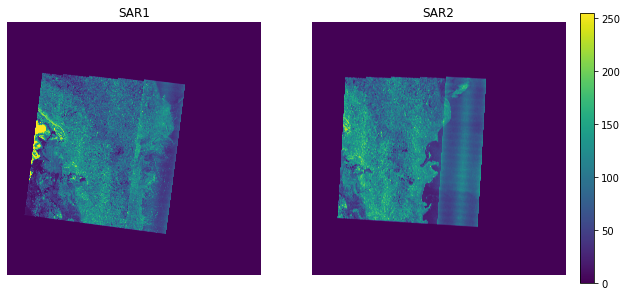

In [54]:
#Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
im1 = ax[0].imshow(n1[1], clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(n2[1], clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im2, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR1")
ax[1].set_title("SAR2")

#ax[0].set_xlim([0.28e6, 0.62e6]) 
#ax[0].set_ylim([0.16e6, 0.6e6])

#ax[1].set_xlim([0.28e6, 0.62e6]) 
#ax[1].set_ylim([0.16e6, 0.6e6])
plt.show()




In [56]:
# Close the dataset
f2 = None
f3 = None

In [57]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 49994
Domain filter: 50000 -> 50000
Keypoints matched 5.154311895370483
Ratio test 0.600000 found 952 keypoints
MaxDrift filter: 952 -> 949
LSTSQ filter: 949 -> 949


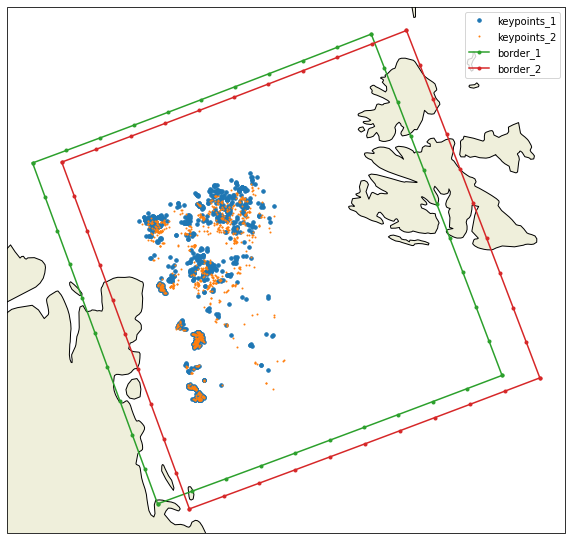

In [58]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree(), markersize=7)
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree(), markersize=2)
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

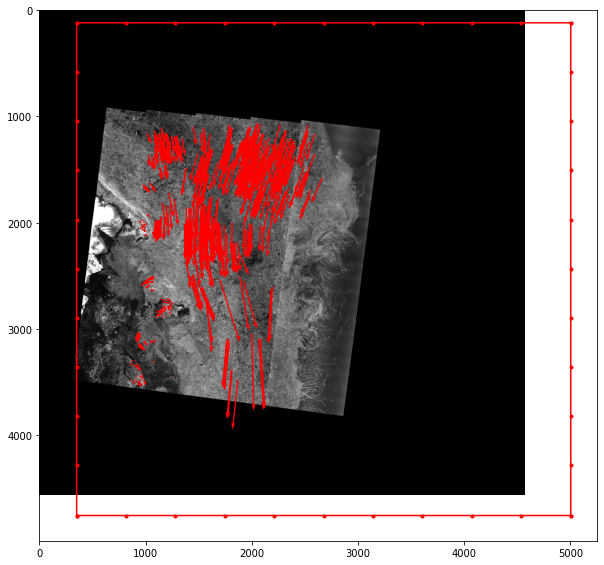

In [59]:

# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b, n1lat2b, 'r.-')

plt.show()
#filename = '/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2500m/FT_example_HH#_1image.png'
#plt.savefig(filename, dpi=300, bbox_inches='tight')

In [60]:
# get lon/lat coordinates of the border of images
# when using .tiff instead of .safe bounds include nodata area around that makes the extent bigger than needed
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()

In [61]:
# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

#Get bound in rows and columns correspoding to the image borders
r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
               
min_row, max_row, min_col, max_col = min(r), max(r), min(c), max(c)

In [62]:
from osgeo import osr

srs = osr.SpatialReference()
srs.ImportFromProj4(proj4)
wkt = srs.ExportToWkt()
wkt

'PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",77.5],PARAMETER["central_meridian",-25],PARAMETER["standard_parallel_1",77.5],PARAMETER["standard_parallel_2",77.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [63]:
# Extract the subset grid out of the model grid based on the image bounds
#That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
X_subset = X[min_col:max_col+1]
Y_subset = Y[min_row:max_row+1]
lon_subset = lon[min_row:max_row+1, min_col:max_col+1]
lat_subset = lat[min_row:max_row+1, min_col:max_col+1]


# Prepare coordinates for patern matching input
lon1pm = lon_subset.data
lat1pm = lat_subset.data

# Set up coordinates in meters for visualizing the pattern matching results.
x1pm, y1pm = np.meshgrid(X_subset, Y_subset)

In [64]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm,best_ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=200,
                                                           max_border=200,
                                                           angles=[-15,-12, -9,-6, -3, 0, 3, 6, 9, 12,15])

/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.me

/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


100% 04226.8 00056.3 03572.0 00091.0 -15.0 1.00 0nan
 Pattern matching - OK! (548 sec)


In [70]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching1(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, img_size = 35,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=50,
                                                           max_border=50,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


80% 02070.8 00931.3 01639.0 00917.0 -12.0 1.00 0nann1% 03507.8 03556.3 03029.0 03607.0 -12.0 1.00 0nan01% 03648.8 04447.3 03166.0 04492.0 -12.0 1.00 0nan29% 04492.8 03197.3 03981.0 03338.0 -12.0 1.00 0nan35% 03164.8 02963.3 02698.0 02998.0 -12.0 1.00 0nan50% 04164.8 02275.3 03664.0 02408.0 -12.0 1.00 0nan40% 01539.8 02713.3 01251.0 02750.0 -03.0 0.24 8.7687% 02085.8 00603.3 01653.0 00597.0 -12.0 1.00 0nan92% 02617.8 00384.3 02167.0 00427.0 -12.0 1.00 0nan77% 04445.8 01056.3 03934.0 01238.0 -12.0 1.00 0nan92% 04179.8 00384.3 03677.0 00558.0 -12.0 1.00 0nan94% 01429.8 00322.3 01019.0 00267.0 -12.0 1.00 0nan78% 01695.8 00994.3 01338.0 01027.0 +00.0 0.64 6.49
 Pattern matching - OK! ( 81 sec)


In [22]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, best_ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=100,
                                                           max_border=100,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)
/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/opt/conda/lib/python

/home/jovyan/packages/2022-2023_48h_experiment/./nersc_drift_algorithm/sea_ice_drift/pmlib_with_ssim.py:60: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/opt/conda/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:251: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D


100% 16468.1 00037.2 14519.0 00723.0 -12.0 1.00 0nan90% 13156.1 01912.2 11335.0 02320.0 -12.0 1.00 0nan79% 13156.1 03787.2 11347.0 04190.0 -12.0 1.00 0nan
 Pattern matching - OK! (182 sec)


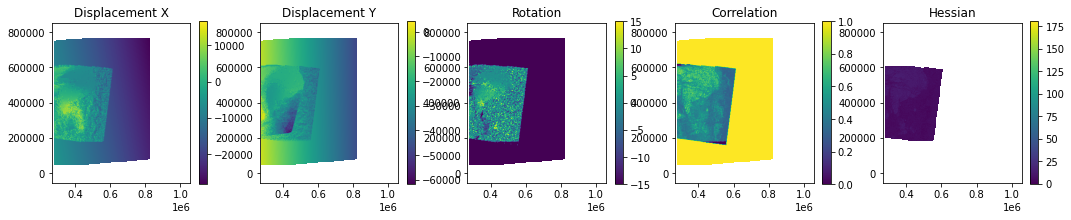

In [41]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower')
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlim([x1pm.min()-10000, x1pm.max()-210000])
    ax[i].set_ylim([y1pm.min()+110000, y1pm.max()-160000])

plt.show()

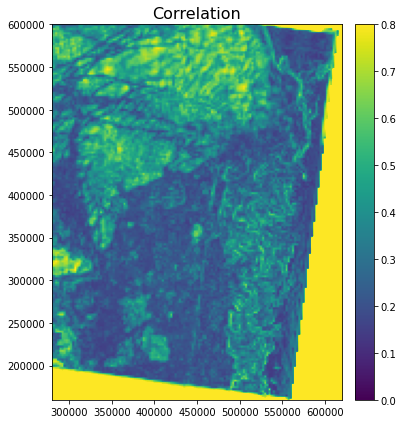

In [65]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('Correlation', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
#im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 1,  cmap='viridis')
# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(rpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.8, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


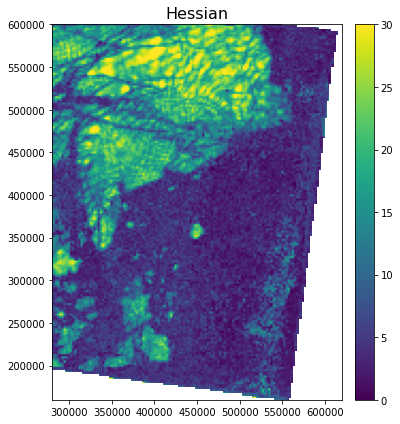

In [66]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('Hessian', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
#im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 1,  cmap='viridis')
# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 30, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


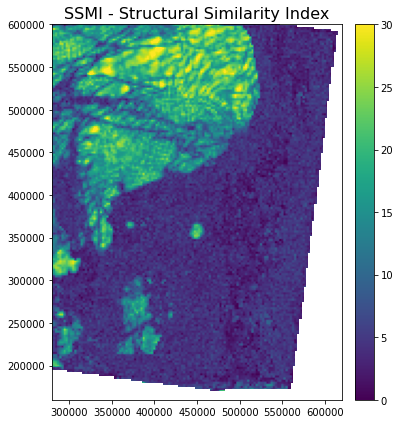

In [74]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
#im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 1,  cmap='viridis')
# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 30, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


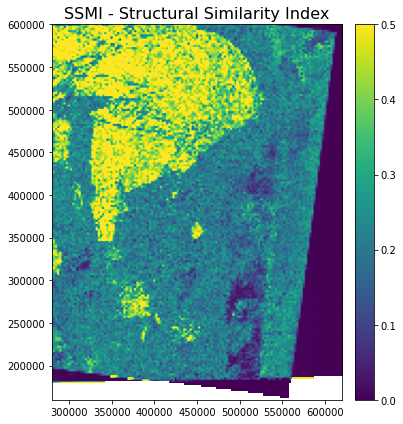

In [74]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.5,  cmap='viridis')
# Display the data with a colormap that provides better contrast and understanding
#im = ax.imshow(hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 30, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


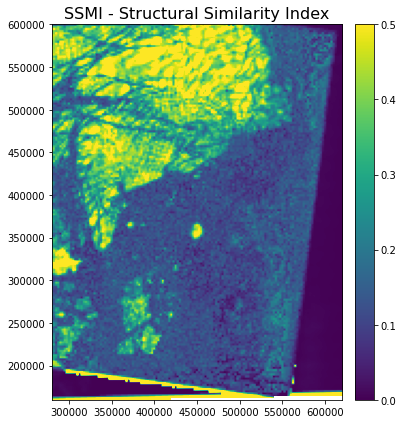

In [258]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.5, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


In [260]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=100,
                                                           max_border=100,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in divide


100% 03867.8 00041.3 03325.0 00146.0 -12.0 1.00 0nan34% 01148.8 02947.3 00762.0 02738.0 -12.0 0.25 3.0429% 04039.8 03181.3 03493.0 03235.0 -12.0 1.00 0nan
 Pattern matching - OK! (133 sec)


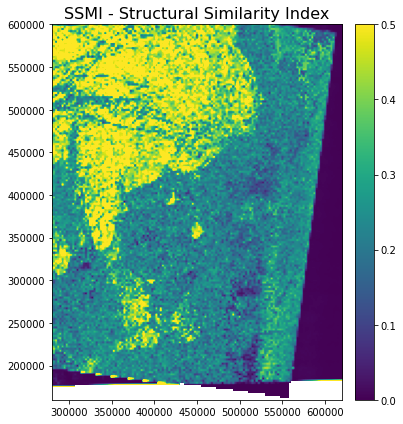

In [48]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
#ax.set_xlabel('Longitude (in projection units)', fontsize=14)
#ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower',vmin = 0, vmax = 0.5, cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
#cbar.set_label('SSIM Value', fontsize=14)


# Set fewer x and y ticks
ax.tick_params(axis='both')#, labelsize=12)
ax.set_xlim([0.28e6, 0.62e6]) 
ax.set_ylim([0.16e6, 0.6e6])


plt.tight_layout()

# Save plot
#plt.savefig("/home/jovyan/experiment_data/2022-2023_48h_experiment/figures/ssim_alg_sar2.png", dpi=300, bbox_inches='tight')


plt.show()


In [203]:
# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

model_d = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')

n1.reproject(model_d) 
n1b1 = n1[1]
n1.undo()

n2.reproject(model_d) 
n2b1 = n2[1]
n2.undo()

#### extra

In [77]:
formatted_timestamp = HH_pairs[1][0].timestamp.strftime('%Y-%m-%dT%H:%M:%S')
print(HH_pairs[1][0].timestamp, formatted_timestamp)
#%store  formatted_timestamp

2023-02-12 08:01:51 2023-02-12T08:01:51


In [ ]:
t_sar1 = '2023-02-12T08:01:51'